In [1]:
import torch 
from stimulus import *
from BIRNN import *
import matplotlib.pyplot as plt 

memory_size = 128
in_emb = memory_size//4
mem_lay = 1
inputs_dim = 2
decisions = 3
typeCell = 'BEF' ## options 'GRU' , 'BEF' , and 'BRC'

sensor = ResMLP(inputs_dim, in_emb, [64,64,64])
actor = ResMLP(memory_size, decisions, [64,64,64])

model = SenseMemAct(sensor, actor, in_sz=in_emb, mem_sz=memory_size, 
                    mem_lay=mem_lay, decisions=decisions, type = typeCell)

In [2]:
# load model
modelfname = f'./checkpoint_{typeCell}.pth'
state = torch.load(modelfname, map_location=torch.device('cpu'))
model.load_state_dict(state)
print('Model has',torch.sum(torch.tensor([p.numel() for p in model.parameters()])).item(), 'parameters')

Model has 133859 parameters


In [3]:
print(model.mem, model.sense, model.act, sep = '\n\n')

nBEFRC(
  (ff_ia): Linear(in_features=32, out_features=128, bias=False)
  (ff_ha): Linear(in_features=128, out_features=128, bias=False)
  (ff_ib): Linear(in_features=32, out_features=128, bias=False)
  (ff_hb): Linear(in_features=128, out_features=128, bias=False)
  (ff_ic): Linear(in_features=32, out_features=128, bias=False)
  (ff_hc): Linear(in_features=128, out_features=128, bias=False)
  (ff_id): Linear(in_features=32, out_features=128, bias=False)
  (ff_hd): Linear(in_features=128, out_features=128, bias=False)
  (ff_ie): Linear(in_features=32, out_features=128, bias=False)
  (ff_he): Linear(in_features=128, out_features=128, bias=False)
  (ff_io): Linear(in_features=32, out_features=128, bias=False)
)

ResMLP(
  (head): Linear(in_features=2, out_features=64, bias=True)
  (layers): ModuleList(
    (0-1): 2 x Linear(in_features=64, out_features=64, bias=True)
  )
  (tail): Linear(in_features=64, out_features=32, bias=True)
  (activ): ReLU()
)

ResMLP(
  (head): Linear(in_features

torch.Size([128, 128])


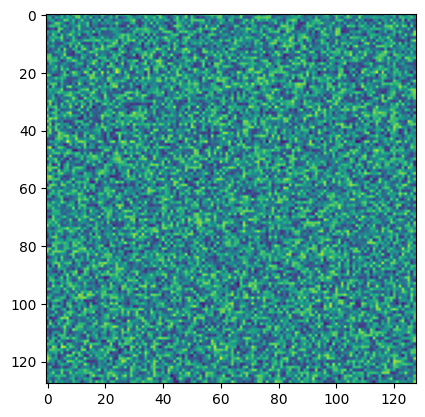

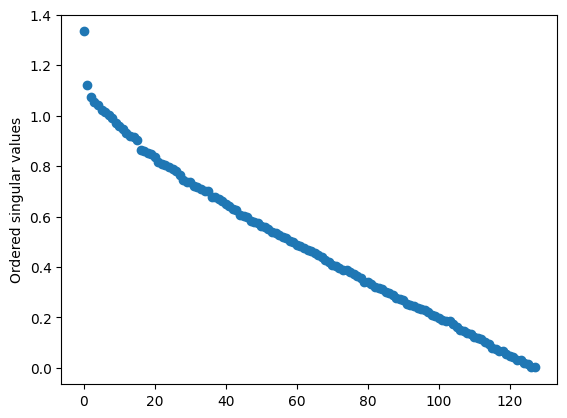

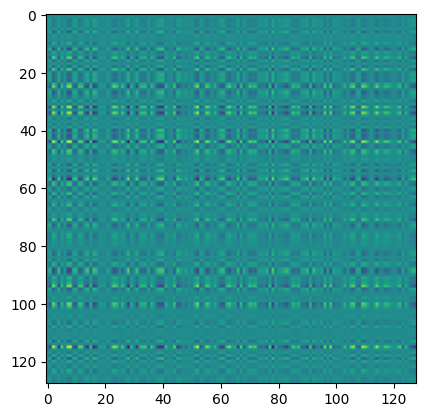

In [4]:
# weights of the linear layer that combines memory 'h' to produce bifurcation parameter 'a'
if typeCell != 'GRU':
    print(model.mem.ff_ha.weight.shape)
    w_mat = model.mem.ff_ha.weight.detach()
    plt.imshow(w_mat)
    plt.show()

    u,s,v = torch.linalg.svd(w_mat)
    plt.scatter(torch.arange(len(s)), s)
    plt.ylabel('Ordered singular values')
    plt.show()

    s[1:] = 0
    plt.imshow(u@torch.diag(s)@v)

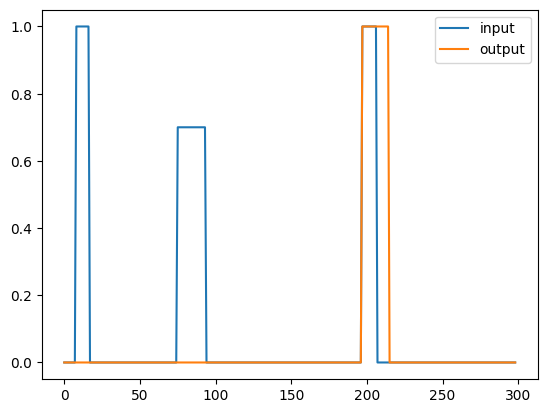

In [5]:
stimG = StimGenerator(dt=.1)
d_i, d_o = stimG.get_batch_data(1)
d_i, d_o = stimG.extend_sim(30, d_i, d_o)
# d_i, d_o = stimG.concat_sim(d_i, d_o)

plt.plot(d_i[0], label = 'input')
plt.plot(d_o[0], label = 'output')
plt.legend()
plt.show()

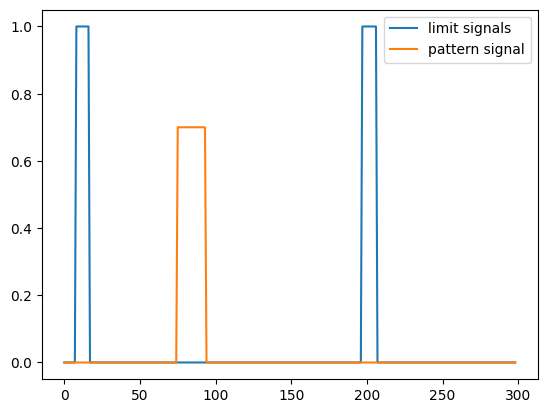

In [6]:
B, L = d_i.shape
mod_in = torch.zeros((B,L,2))
mod_in[...,0][d_i == 1] = 1
mod_in[...,1][d_i != 1] = d_i[d_i!=1]
plt.plot(mod_in[0,:,0], label = 'limit signals')
plt.plot(mod_in[0,:,1], label = 'pattern signal')
plt.legend()
plt.show()
# pred = model()

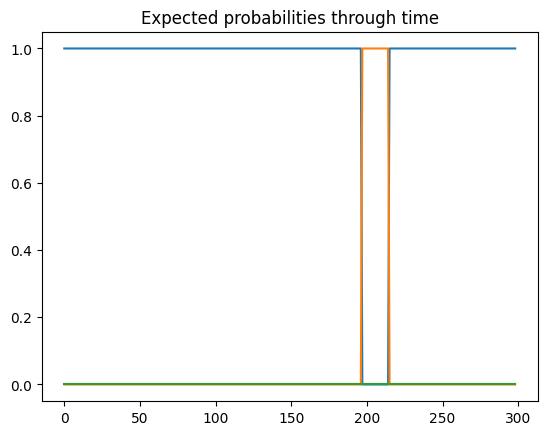

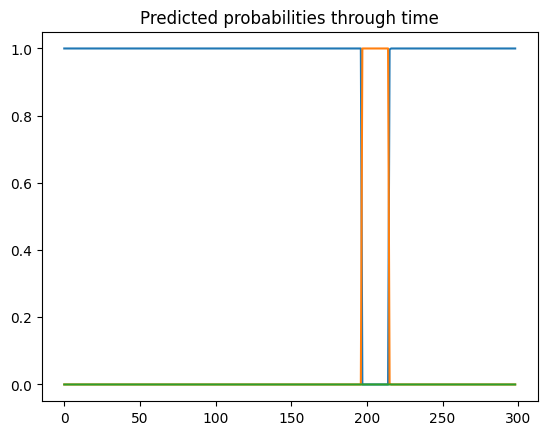

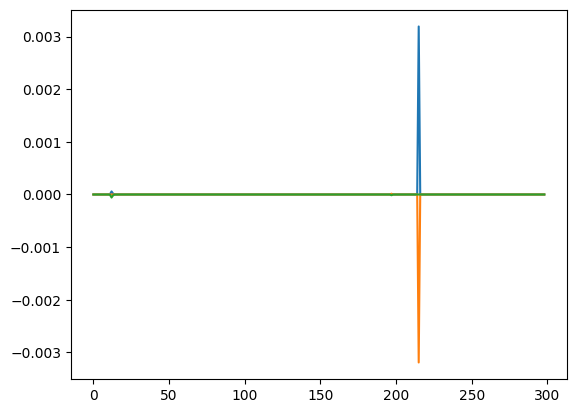

In [7]:
dc = decode_choice(d_o)
dc.shape
plt.plot(dc[0])
plt.title('Expected probabilities through time')
plt.show()

with torch.no_grad():
    pred_c = model(mod_in)
    plt.plot(pred_c[0])
    plt.title('Predicted probabilities through time') 
    plt.show()
    plt.plot(dc[0] - pred_c[0])
    plt.show()

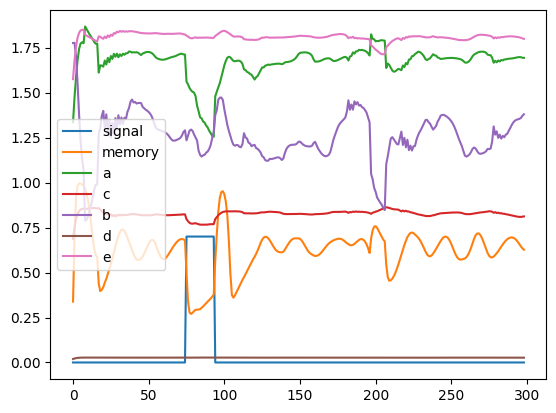

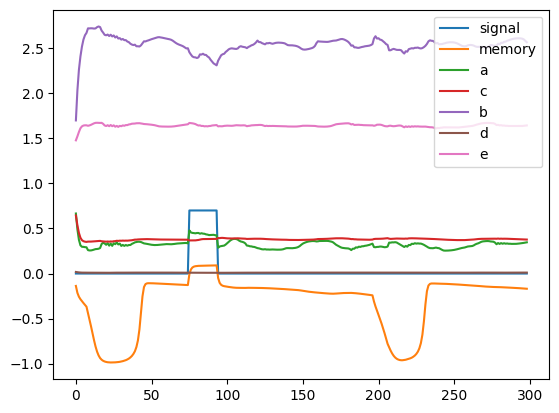

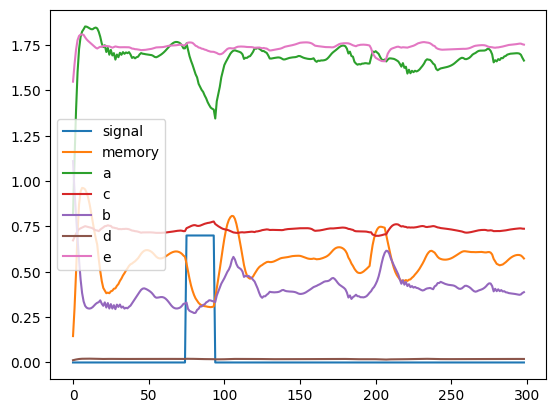

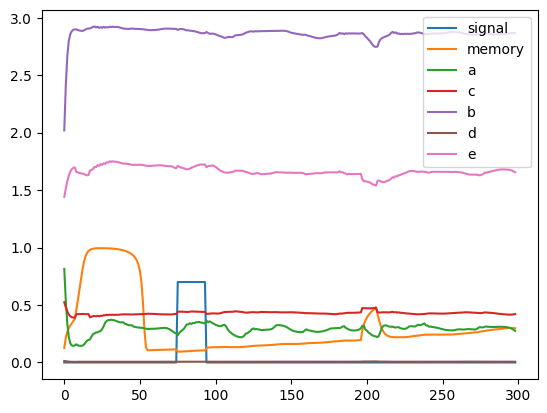

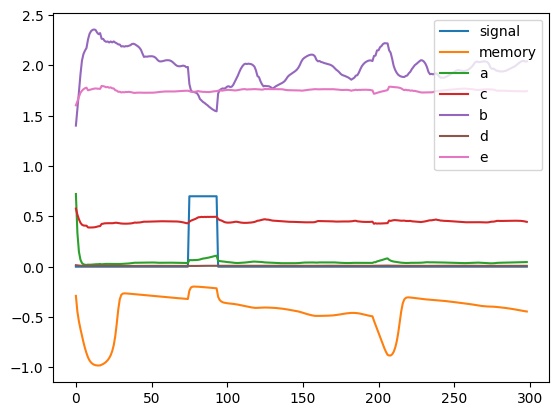

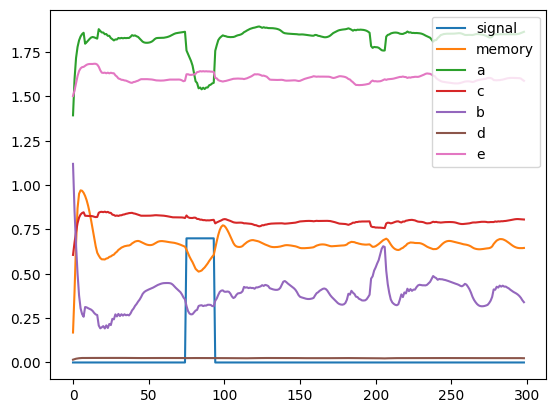

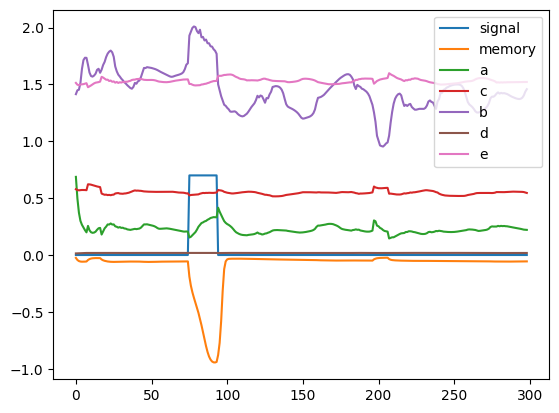

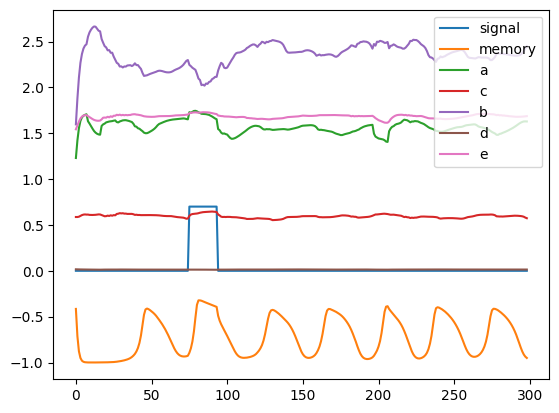

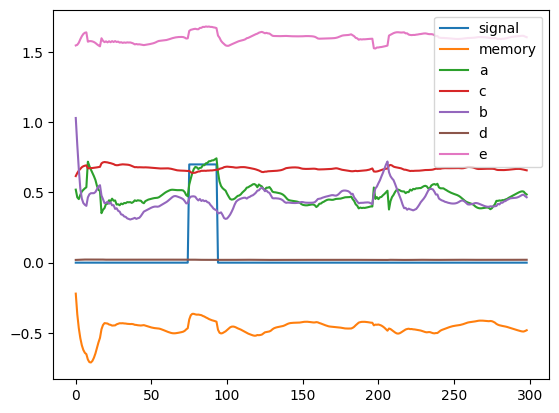

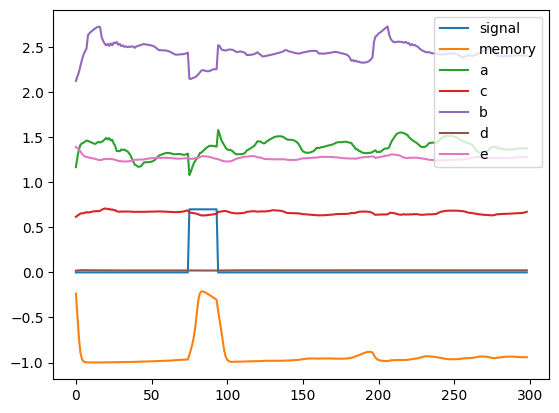

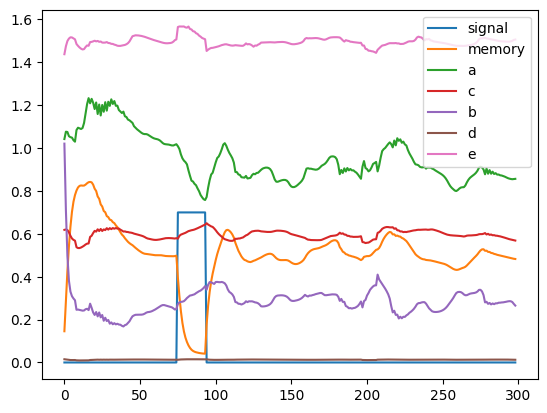

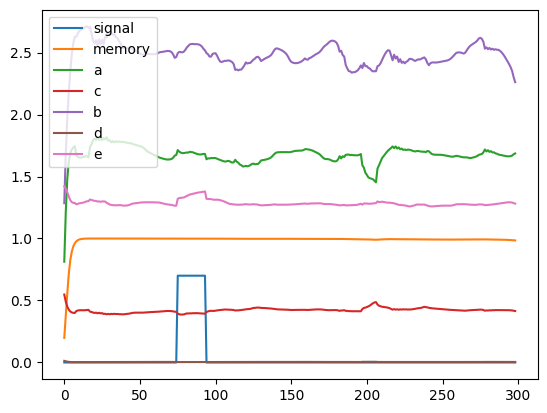

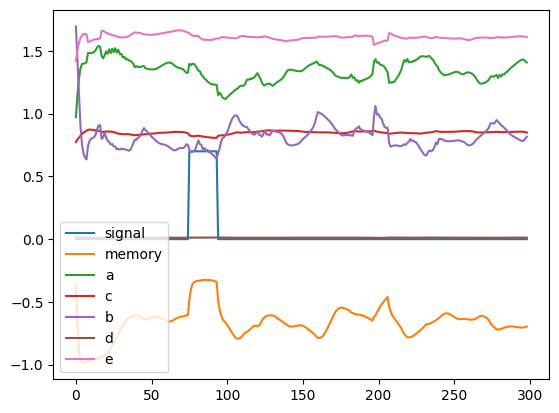

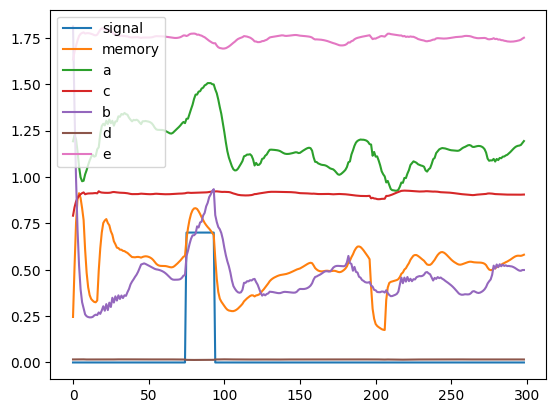

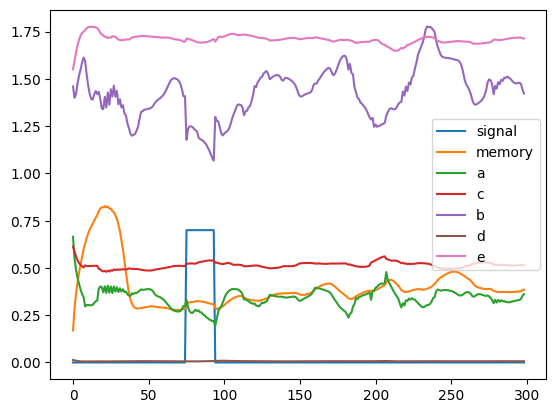

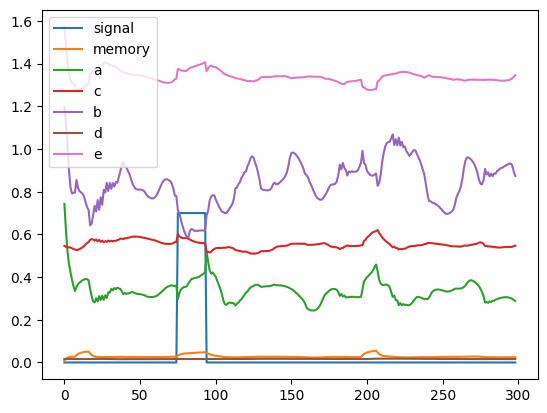

In [8]:
# dive into memory

with torch.no_grad():
    if typeCell == 'BEF':
        a,b,c,d,e,pred_c = model.forward(x=mod_in, debug_mem=True)
    elif typeCell == 'BRC':
        a,c,pred_c = model.forward(x=mod_in, debug_mem=True)
    else:
        pred_c = model.forward(x=mod_in, debug_mem=True) ### int he case of GRU, the only parameter being retrieved is the system speed C? 
    # model.mem.ff_ha.weight = torch.nn.Parameter(u@torch.diag(s)@v)
    # pred_pc = model.forward(x=mod_in, debug_mem=True)

for i in range(0,128,8):
    plt.clf()
    plt.plot(mod_in[0,:,1], label = 'signal')
    plt.plot(pred_c[0,:,i], label= 'memory')
    if typeCell != 'GRU':
        plt.plot(a[0,:,i], label= 'a')
        plt.plot(c[0,:,i], label= 'c')
        if typeCell == 'BEF':
            plt.plot(b[0,:,i], label= 'b')
            plt.plot(d[0,:,i], label= 'd')
            plt.plot(e[0,:,i], label= 'e')
    
    plt.legend()
    # plt.plot(pred_pc[0,:,i])
    plt.show()


In [9]:
# Enable interactive plot
%matplotlib notebook
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

<IPython.core.display.Javascript object>


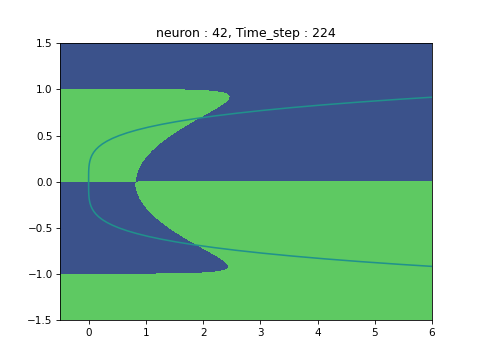

In [10]:
fig, ax = plt.subplots()

hfs = torch.meshgrid(torch.linspace(-1.5,1.5, 100), torch.linspace(-.5,6,100), indexing = 'ij')
hfs = torch.cat((hfs[0].unsqueeze(0), hfs[1].unsqueeze(0)))

ax.set_xlim(-0.5, 6)
ax.set_ylim(-1.5, 1.5)

animation_neuron_nb = 42

def transition(hf, hs, pars):
    # size (B, V)
    a,b,c,d,e = pars['a'],pars['b'],pars['c'],pars['d'],pars['e']
    hfn = hf * (1-c) + c*torch.tanh((a + b*hf**2 - hs)*hf) #0 input response
    hsn = hs*(1-d) + d*(e*hf)**4

    return hfn, hsn 

def animate(frame_num):
    
    pars = {'a': a[0,frame_num,animation_neuron_nb],
            'b': b[0,frame_num,animation_neuron_nb],
            'c': c[0,frame_num,animation_neuron_nb],
            'd': d[0,frame_num,animation_neuron_nb],
            'e': e[0,frame_num,animation_neuron_nb]
            }
    hfn, hsn = transition(hfs[0], hfs[1], pars)
    ax.clear()
    ax.contourf(hfs[1], hfs[0], hfn - hfs[0], 0)
    ax.contour(hfs[1], hfs[0], hsn - hfs[1], 0)
    ax.set_title("neuron : "+ str(animation_neuron_nb) + ", Time_step : " +  str(frame_num))
    


anim = FuncAnimation(fig, animate, frames=299,interval = 2,repeat = True, repeat_delay = 500)
plt.show()